In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray
from src.seir import *
from src.implicit_node import *
from copy import deepcopy

requirements for model run
- travel data frame
- baseline contact
- starting population sizes
- epi params

In [2]:
# validation tolerances:
abs_tol = 0.001 #0.001 max persons difference
rel_tol = 0.0005 #0.05% max difference

In [3]:
params_template = {
  "mu": 0.0,
  "sigma": 0.5,
  "beta": 0.1,
  "gamma": 0.2,
  "omega": 0.1,
  "start_S": [[24, 0], [49, 0]],
  "start_E": [[0, 0], [0, 0]],
  "start_I": [[1, 0], [1, 0]],
  "start_R": [[0, 0], [0, 0]],
  "days": 30,
  "outpath": "outputs/multiple_nodes",
  "phi": [], # fill in after partitioning
  "n_sims": 1,
  "stochastic": "False",
  "n_age": 2,
  "n_nodes": 2,
  "sim_idx": 0, # single deterministic run
  "interval_per_day": 10
}

In [4]:
travel = pd.read_csv('inputs/travel2.csv')

In [5]:
travel

,source,destination,destination_type,age_src,age_dest,n
0,A,A,local,young,young,0
1,A,A,local,old,old,0
2,A,school,contextual,young,young,25
3,A,school,contextual,old,old,0
4,B,B,local,young,young,0
5,B,B,local,old,old,0
6,B,school,contextual,young,young,50
7,B,school,contextual,old,old,0
8,A,B,local,young,young,0
9,A,B,local,old,old,0


In [6]:
contact = pd.read_csv('inputs/contact.csv')

In [8]:
partition = partition_contacts(travel, contact, daily_timesteps=10)
phi_matrix = contact_matrix(partition)

mismatched partitioned and baseline contacts
age_i                              young
age_j                              young
partitioned_per_capita_contacts        1
age1                               young
age2                               young
daily_per_capita_contacts              5
Name: 1, dtype: object


In [9]:
phi_matrix

array([[[[0.16666667, 0.        ],
         [0.        , 0.        ]],

        [[0.33333333, 0.        ],
         [0.        , 0.        ]]],


       [[[0.16666667, 0.        ],
         [0.        , 0.        ]],

        [[0.33333333, 0.        ],
         [0.        , 0.        ]]]])

In [10]:
test1 = deepcopy(params_template)
test1['phi'] = phi_matrix
test1_model = SEIR(test1)
test1_model.seir()
test1_model.final

<xarray.Dataset>
Dimensions:  (age: 2, node: 2, time: 300)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * age      (age) <U5 'young' 'old'
  * node     (node) int64 0 1
Data variables:
    S        (time, node, age) float64 24.0 0.0 49.0 0.0 ... 23.82 0.0 48.63 0.0
    E        (time, node, age) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0009802 0.0
    I        (time, node, age) float64 1.0 0.0 1.0 0.0 ... 0.0 0.009961 0.0
    R        (time, node, age) float64 0.0 0.0 0.0 0.0 ... 1.178 0.0 1.364 0.0

In [11]:
test1_model.beta

0.1

In [12]:
test1_model.stochastic

'False'

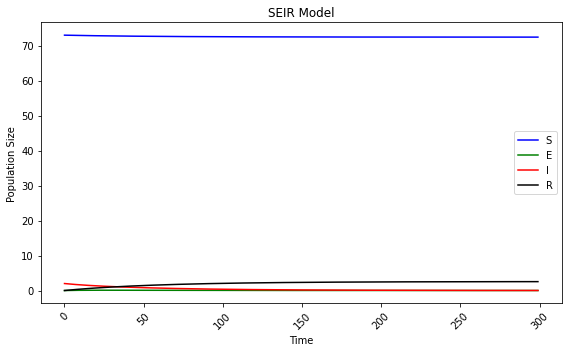

In [13]:
test1_model.plot_timeseries()

In [14]:
def discrete_time_approx(rate, timestep):
    """

    :param rate: daily rate
    :param timestep: timesteps per day
    :return: rate rescaled by time step
    """

    return (1 - (1 - rate)**(1/timestep))

In [15]:
ref_params = {
  "mu": 0.0,
  "sigma": 0.5,
  "beta": 0.1,
  "gamma": 0.2,
  "omega": 0.1,
  "start_S": [[73, 0]],
  "start_E": [[0, 0]],
  "start_I": [[2, 0]],
  "start_R": [[0, 0]],
  "days": 30,
  "outpath": "outputs/single_node",
  "phi": [[[[5/10, 0], [0, 0]]]],
  "n_sims": 1,
  "stochastic": "False",
  "n_age": 2,
  "n_nodes": 1,
  "sim_idx": 0,
  "interval_per_day": 10
}

In [16]:
ref_model = SEIR(ref_params)
ref_model.seir()

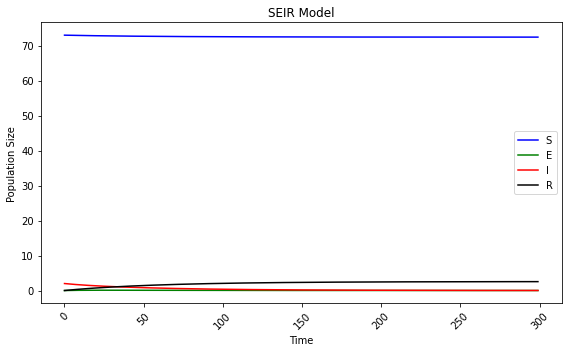

In [17]:
ref_model.plot_timeseries()

In [18]:
def test_partition(test, ref, method=xarray.testing.assert_allclose, **kwargs):

    test_s = xr_summary(test.final.S, sel={'age': 'young'}, timeslice=slice(0, test.duration), sum_over='node')
    ref_s = xr_summary(ref.final.S, sel={'age': 'young'}, timeslice=slice(0, ref.duration), sum_over='node')
    
    diff_s = test_s - ref_s
    
    test_e = xr_summary(test.final.E, sel={'age': 'young'}, timeslice=slice(0, test.duration), sum_over='node')
    ref_e = xr_summary(ref.final.E, sel={'age': 'young'}, timeslice=slice(0, ref.duration), sum_over='node')
    
    diff_e = test_e - ref_e
    
    test_i = xr_summary(test.final.I, sel={'age': 'young'}, timeslice=slice(0, test.duration), sum_over='node')
    ref_i = xr_summary(ref.final.I, sel={'age': 'young'}, timeslice=slice(0, ref.duration), sum_over='node')
    
    diff_i = test_i - ref_i
    
    test_r = xr_summary(test.final.R, sel={'age': 'young'}, timeslice=slice(0, test.duration), sum_over='node')
    ref_r = xr_summary(ref.final.R, sel={'age': 'young'}, timeslice=slice(0, ref.duration), sum_over='node')
    
    diff_r = test_r - ref_r
    
    try:
        method(test_s, ref_s, **kwargs)
    except AssertionError:
        print('Differing values for susceptible timeseries.')
        
    try:
        method(test_e, ref_e, **kwargs)
    except AssertionError:
        print('Differing values for exposed timeseries.')
    
    try:
        method(test_i, ref_i, **kwargs)
    except AssertionError:
        print('Differing values for infected timeseries.')
    
    try:
        method(test_r, ref_r, **kwargs)
    except AssertionError:
        print('Differing values for recovered timeseries.')
        
    return diff_s, diff_e, diff_i, diff_r

In [19]:
s_diff, e_diff, i_diff, r_diff = test_partition(test1_model, ref_model, atol=abs_tol, rtol=rel_tol)

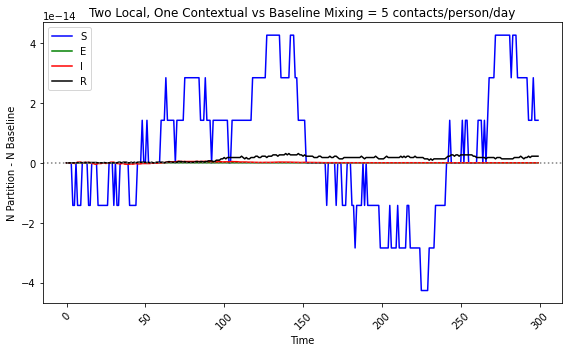

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

s_diff.plot(ax=ax, color='b')
e_diff.plot(ax=ax, color='g')
i_diff.plot(ax=ax, color='r')
r_diff.plot(ax=ax, color='k')

plt.legend(("S", "E", "I", "R"), loc=0)
plt.ylabel("N Partition - N Baseline")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.title("Two Local, One Contextual vs Baseline Mixing = 5 contacts/person/day")
plt.tight_layout()
#ax.set_ylim(-2, 3)
plt.axhline(y=0, c='gray', ls='dotted')

plt.show()

In [21]:
test_partition(test1_model, ref_model, method=xarray.testing.assert_equal)

Differing values for susceptible timeseries.
Differing values for exposed timeseries.
Differing values for infected timeseries.
Differing values for recovered timeseries.


(<xarray.DataArray 'S' (time: 300)>
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.42108547e-14, -1.42108547e-14,  0.00000000e+00, -1.42108547e-14,
        -1.42108547e-14, -1.42108547e-14,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.42108547e-14, -1.42108547e-14,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.42108547e-14, -1.42108547e-14, -1.42108547e-14, -1.42108547e-14,
        -1.42108547e-14, -1.42108547e-14, -1.42108547e-14,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.42108547e-14,  0.00000000e+00,
        -1.42108547e-14, -1.42108547e-14,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.42108547e-14, -1.42108547e-14, -1.42108547e-14, -1.42108547e-14,
        -1.42108547e-14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.42108547e-14,  0.00000000e+00,  0.0000000

# Sensitivity analysis: contact rate

In [22]:
def update_contact_rate(contact_df, new_rate, age1='young', age2='young'):
    
    contact_idx = contact_df.set_index(['age1', 'age2'])
    contact_dict = contact_idx.to_dict()
    contact_dict['daily_per_capita_contacts'][(age1, age2)] = new_rate
    updated_df = pd.DataFrame.from_dict(contact_dict).reset_index()
    updated_df.columns = ['age1', 'age2', 'daily_per_capita_contacts']
    
    return updated_df

In [23]:
update_contact_rate(contact, 0.3)

,age1,age2,daily_per_capita_contacts
0,old,old,0.0
1,old,young,0.0
2,young,old,0.0
3,young,young,0.3


In [24]:
polymod = pd.read_csv('~/COVID19/SEIR-city/data/Cities_Data/ContactMatrixAll_5AgeGroups.csv', header=None)

In [25]:
max_cr = polymod.max().max()
min_cr = polymod.min().min()
print(min_cr, max_cr)

0.18975609071541075 10.236283859611031


In [26]:
max_contact = update_contact_rate(contact, max_cr)
max_partition = partition_contacts(travel, max_contact, daily_timesteps=10)
max_phi_matrix = contact_matrix(max_partition)

mismatched partitioned and baseline contacts
age_i                                young
age_j                                young
partitioned_per_capita_contacts    2.04726
age1                                 young
age2                                 young
daily_per_capita_contacts          10.2363
Name: 1, dtype: object


In [27]:
test_max = deepcopy(params_template)
test_max['phi'] = max_phi_matrix
test_max_model = SEIR(test_max)
test_max_model.seir()

In [28]:
ref_max = deepcopy(ref_params)
ref_max['phi'] = [[[[max_cr/10, 0], [0, 0]]]]
ref_max_model = SEIR(ref_max)
ref_max_model.seir()

In [29]:
ds_max, de_max, di_max, dr_max = test_partition(test_max_model, ref_max_model, atol=abs_tol, rtol=rel_tol)

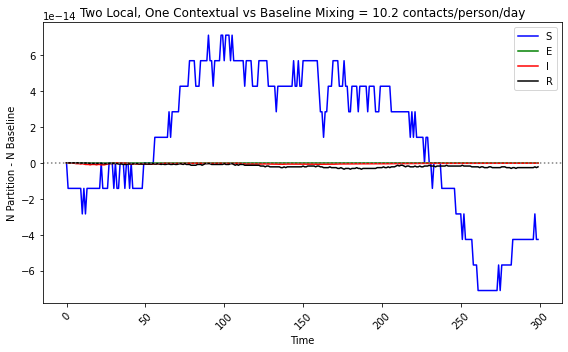

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ds_max.plot(ax=ax, color='b')
de_max.plot(ax=ax, color='g')
di_max.plot(ax=ax, color='r')
dr_max.plot(ax=ax, color='k')

plt.legend(("S", "E", "I", "R"), loc=0)
plt.ylabel("N Partition - N Baseline")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.title("Two Local, One Contextual vs Baseline Mixing = 10.2 contacts/person/day")
plt.tight_layout()
#ax.set_ylim(-2, 3)
plt.axhline(y=0, c='gray', ls='dotted')

plt.show()

In [31]:
min_contact = update_contact_rate(contact, min_cr)
min_partition = partition_contacts(travel, min_contact, daily_timesteps=10)
min_phi_matrix = contact_matrix(min_partition)

test_min = deepcopy(params_template)
test_min['phi'] = min_phi_matrix
test_min_model = SEIR(test_min)
test_min_model.seir()

ref_min = deepcopy(ref_params)
ref_min['phi'] = [[[[min_cr/10, 0], [0, 0]]]]
ref_min_model = SEIR(ref_min)
ref_min_model.seir()

mismatched partitioned and baseline contacts
age_i                                  young
age_j                                  young
partitioned_per_capita_contacts    0.0379512
age1                                   young
age2                                   young
daily_per_capita_contacts           0.189756
Name: 1, dtype: object


In [32]:
ds_min, de_min, di_min, dr_min = test_partition(test_min_model, ref_min_model, atol=abs_tol, rtol=rel_tol)

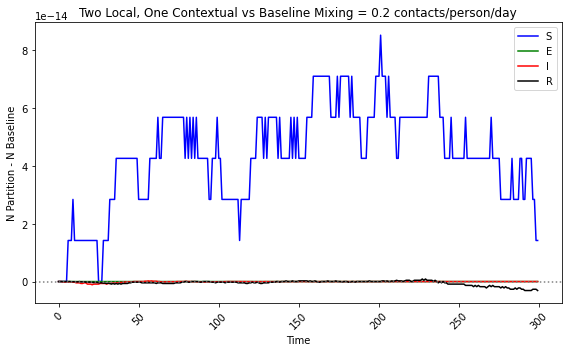

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ds_min.plot(ax=ax, color='b')
de_min.plot(ax=ax, color='g')
di_min.plot(ax=ax, color='r')
dr_min.plot(ax=ax, color='k')

plt.legend(("S", "E", "I", "R"), loc=0)
plt.ylabel("N Partition - N Baseline")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.title("Two Local, One Contextual vs Baseline Mixing = 0.2 contacts/person/day")
plt.tight_layout()
#ax.set_ylim(-2,3)
plt.axhline(y=0, c='gray', ls='dotted')

plt.show()

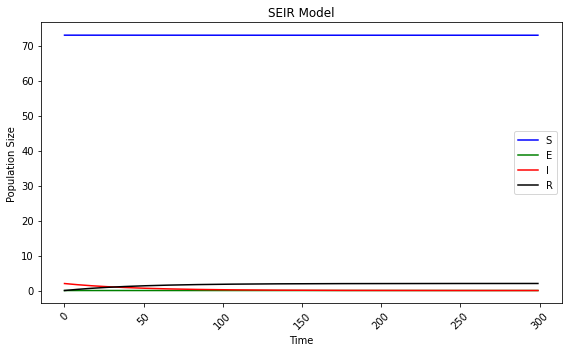

In [34]:
ref_min_model.plot_timeseries()

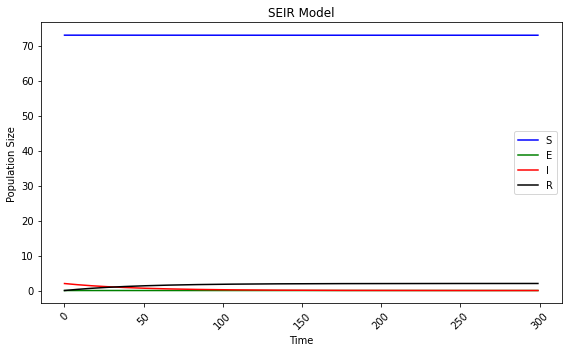

In [35]:
test_min_model.plot_timeseries()

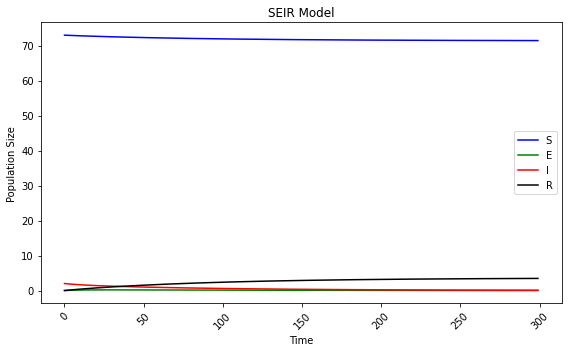

In [36]:
ref_max_model.plot_timeseries()

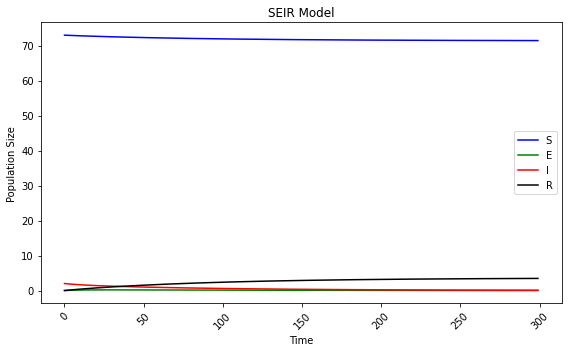

In [37]:
test_max_model.plot_timeseries()

# Sensitivity analysis: population size

In [38]:
pop_template = {
  "mu": 0.0,
  "sigma": 0.5,
  "beta": 0.1,
  "gamma": 0.2,
  "omega": 0.1,
  "start_S": [[24, 0], [49, 0]],
  "start_E": [[0, 0], [0, 0]],
  "start_I": [[1, 0], [1, 0]],
  "start_R": [[0, 0], [0, 0]],
  "days": 30,
  "outpath": "outputs/multiple_nodes",
  "phi": [], # fill in after partitioning
  "n_sims": 1,
  "stochastic": "False",
  "n_age": 2,
  "n_nodes": 2,
  "sim_idx": 0, # single deterministic run
  "interval_per_day": 10
}

In [39]:
def update_travel(travel_df, new_count, source, destination, age_src='young', age_dest='young'):
    
    travel_idx = travel_df.set_index(['source', 'destination', 'age_src', 'age_dest'])
    travel_dict = travel_idx.to_dict()
    travel_dict['n'][(source, destination, age_src, age_dest)] = new_count
    updated_df = pd.DataFrame.from_dict(travel_dict).reset_index()
    updated_df.columns = ['source', 'destination', 'age_src', 'age_dest', 'destination_type', 'n']
    
    return updated_df

In [40]:
def update_start_pop(travel_df):
    
    grouped = travel_df.groupby(['source', 'age_src'])['n'].sum().reset_index()
    
    nodes = sorted(travel_df['source'].unique())
    ages = sorted(travel_df['age_src'].unique(), reverse=True)

    pop_arr_s = np.zeros([len(nodes), len(ages)])
    pop_arr_e = np.zeros([len(nodes), len(ages)])
    pop_arr_i = np.zeros([len(nodes), len(ages)])
    pop_arr_r = np.zeros([len(nodes), len(ages)])
    
    for i, node in enumerate(nodes):
        for j, age in enumerate(ages):
            new_total = grouped[(grouped['source']==node) & (grouped['age_src']==age)]['n'].item()
            if new_total > 2:
                pop_arr_s[i, j] = new_total-1
                pop_arr_i[i, j] = 1

    return pop_arr_s, pop_arr_e, pop_arr_i, pop_arr_r

In [41]:
new_travel = update_travel(travel, 50, source='A', destination='A')
pop_s, pop_e, pop_i, pop_r = update_start_pop(new_travel)

# Sensitivity analysis: additional nodes

In [42]:
travel3 = pd.read_csv('inputs/travel3.csv')

In [ ]:
travel3

In [43]:
partition3 = partition_contacts(travel3, contact, daily_timesteps=10)
phi_matrix3 = contact_matrix(partition3)
pop_s, pop_e, pop_i, pop_r = update_start_pop(travel3)
test3 = deepcopy(params_template)
test3['phi'] = phi_matrix3
test3['start_S'] = pop_s
test3['start_E'] = pop_e
test3['start_I'] = pop_i
test3['start_R'] = pop_r
test3['n_nodes'] = 3

mismatched partitioned and baseline contacts
age_i                              young
age_j                              young
partitioned_per_capita_contacts      1.5
age1                               young
age2                               young
daily_per_capita_contacts              5
Name: 1, dtype: object


In [44]:
test3_model = SEIR(test3)
test3_model.seir()

In [45]:
ref3 = deepcopy(params_template)
ref3['phi'] = [[[[5/10, 0], [0, 0]]]]
ref3_s = np.array([sorted(travel3.groupby(['age_src'])['n'].sum(), reverse=True)])
ref3['start_S'] = ref3_s[0, 0] - 3
ref3['start_E'] = np.array([[0, 0]])
ref3['start_I'] = np.array([[3, 0]])
ref3['start_R'] = np.array([[0, 0]])
ref3['n_nodes'] = 1

In [46]:
ref3_model = SEIR(ref3)
ref3_model.seir()

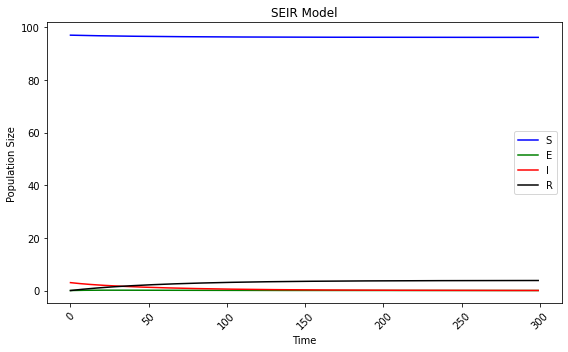

In [47]:
test3_model.plot_timeseries()

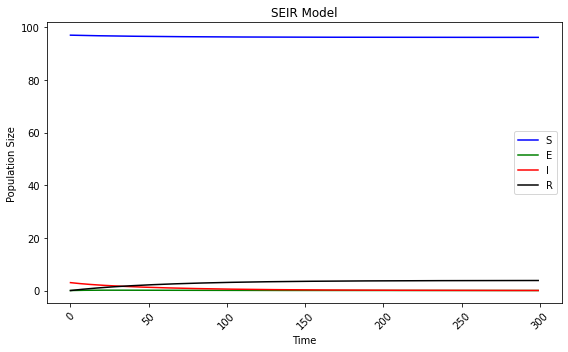

In [48]:
ref3_model.plot_timeseries()

In [49]:
ref3['start_S']

97

In [50]:
s3_diff, e3_diff, i3_diff, r3_diff = test_partition(test3_model, ref3_model, atol=abs_tol, rtol=rel_tol)

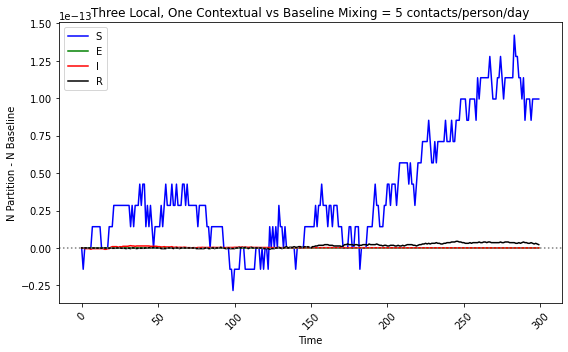

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

s3_diff.plot(ax=ax, color='b')
e3_diff.plot(ax=ax, color='g')
i3_diff.plot(ax=ax, color='r')
r3_diff.plot(ax=ax, color='k')

plt.legend(("S", "E", "I", "R"), loc=0)
plt.ylabel("N Partition - N Baseline")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.title("Three Local, One Contextual vs Baseline Mixing = 5 contacts/person/day")
plt.tight_layout()
#ax.set_ylim(-2, 3)
plt.axhline(y=0, c='gray', ls='dotted')

plt.show()

In [52]:
local3v2_contact5_s = s3_diff - s_diff
local3v2_contact5_e = e3_diff - e_diff
local3v2_contact5_i = i3_diff - i_diff
local3v2_contact5_r = r3_diff - r_diff

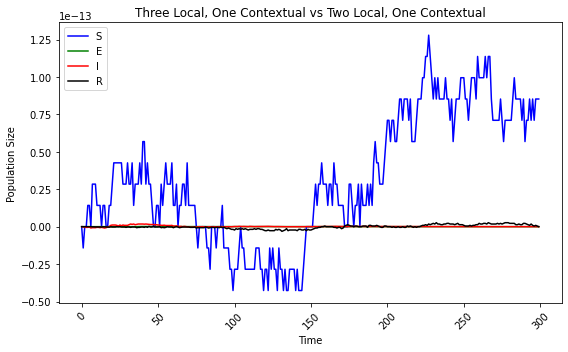

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

local3v2_contact5_s.plot(ax=ax, color='b')
local3v2_contact5_e.plot(ax=ax, color='g')
local3v2_contact5_i.plot(ax=ax, color='r')
local3v2_contact5_r.plot(ax=ax, color='k')

plt.legend(("S", "E", "I", "R"), loc=0)
plt.ylabel("Population Size")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.title("Three Local, One Contextual vs Two Local, One Contextual")
plt.tight_layout()

plt.show()

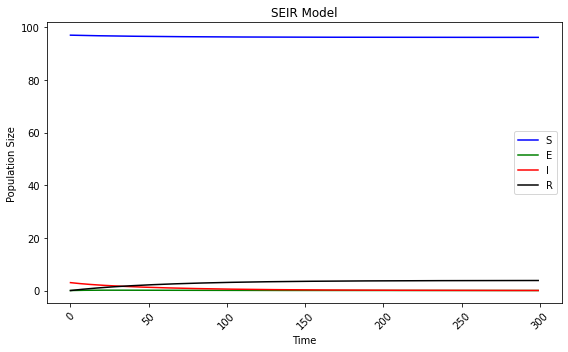

In [54]:
ref3_model.plot_timeseries()

In [55]:
test3_model.final

<xarray.Dataset>
Dimensions:  (age: 2, node: 3, time: 300)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * age      (age) <U5 'young' 'old'
  * node     (node) int64 0 1 2
Data variables:
    S        (time, node, age) float64 24.0 0.0 49.0 0.0 ... 48.58 0.0 23.79 0.0
    E        (time, node, age) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0005362 0.0
    I        (time, node, age) float64 1.0 0.0 1.0 0.0 ... 0.0 0.006034 0.0
    R        (time, node, age) float64 0.0 0.0 0.0 0.0 0.0 ... 1.409 0.0 1.2 0.0

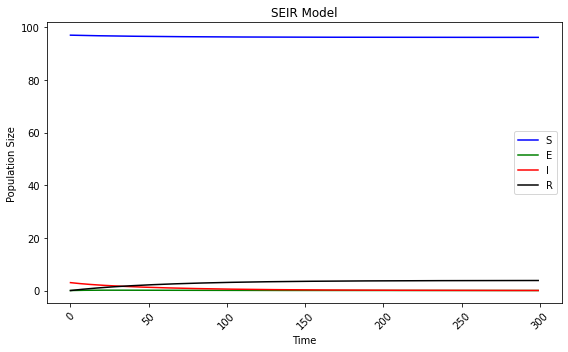

In [56]:
test3_model.plot_timeseries()

In [57]:
partition3_min = partition_contacts(travel3, min_contact, daily_timesteps=10)
phi_matrix3_min = contact_matrix(partition3_min)

test3_min = deepcopy(test3)
test3_min['phi'] = phi_matrix3_min

ref3_min = deepcopy(ref3)
ref3_min['phi'] = [[[[min_cr/10, 0], [0, 0]]]]

test3_min_model = SEIR(test3_min)
test3_min_model.seir()

ref3_min_model = SEIR(ref3_min)
ref3_min_model.seir()

mismatched partitioned and baseline contacts
age_i                                  young
age_j                                  young
partitioned_per_capita_contacts    0.0569268
age1                                   young
age2                                   young
daily_per_capita_contacts           0.189756
Name: 1, dtype: object


In [58]:
s3_diff_min, e3_diff_min, i3_diff_min, r3_diff_min = test_partition(test3_min_model, ref3_min_model, atol=abs_tol, rtol=rel_tol)


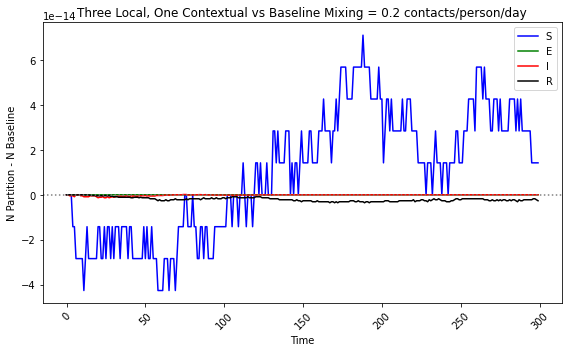

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

s3_diff_min.plot(ax=ax, color='b')
e3_diff_min.plot(ax=ax, color='g')
i3_diff_min.plot(ax=ax, color='r')
r3_diff_min.plot(ax=ax, color='k')

plt.legend(("S", "E", "I", "R"), loc=0)
plt.ylabel("N Partition - N Baseline")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.title("Three Local, One Contextual vs Baseline Mixing = 0.2 contacts/person/day")
plt.tight_layout()
plt.axhline(y=0, c='gray', ls='dotted')
#ax.set_ylim(-2, 3)

plt.show()

In [61]:
partition3_max = partition_contacts(travel3, max_contact, daily_timesteps=10)
phi_matrix3_max = contact_matrix(partition3_max)

test3_max = deepcopy(test3)
test3_max['phi'] = phi_matrix3_max

ref3_max = deepcopy(ref3)
ref3_max['phi'] = [[[[max_cr/10, 0], [0, 0]]]]

test3_max_model = SEIR(test3_max)
test3_max_model.seir()

ref3_max_model = SEIR(ref3_max)
ref3_max_model.seir()

mismatched partitioned and baseline contacts
age_i                                young
age_j                                young
partitioned_per_capita_contacts    3.07089
age1                                 young
age2                                 young
daily_per_capita_contacts          10.2363
Name: 1, dtype: object


In [62]:
s3_diff_max, e3_diff_max, i3_diff_max, r3_diff_max = test_partition(test3_max_model, ref3_max_model, atol=abs_tol, rtol=rel_tol)


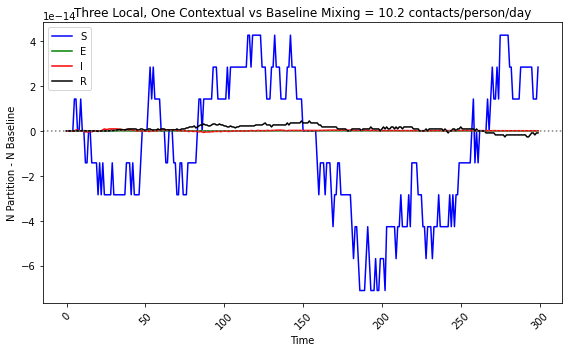

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

s3_diff_max.plot(ax=ax, color='b')
e3_diff_max.plot(ax=ax, color='g')
i3_diff_max.plot(ax=ax, color='r')
r3_diff_max.plot(ax=ax, color='k')

plt.legend(("S", "E", "I", "R"), loc=0)
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.title("Three Local, One Contextual vs Baseline Mixing = 10.2 contacts/person/day")
plt.tight_layout()
plt.ylabel("N Partition - N Baseline")
plt.axhline(y=0, c='gray', ls='dotted')
#ax.set_ylim(-2, 3)

plt.show()

# 16 Nodes

In [64]:
travel16 = pd.read_csv('inputs/travel16.csv')
partition16 = partition_contacts(travel16, contact, daily_timesteps=10)
phi_matrix16 = contact_matrix(partition16)
pop_s16, pop_e16, pop_i16, pop_r16 = update_start_pop(travel16)

test16 = deepcopy(params_template)
test16['phi'] = phi_matrix16
test16['start_S'] = pop_s16
test16['start_E'] = pop_e16
test16['start_I'] = pop_i16
test16['start_R'] = pop_r16
test16['n_nodes'] = 16

ref16 = deepcopy(params_template)
ref16['phi'] = [[[[5/10, 0], [0, 0]]]]
ref16_s = np.array([sorted(travel16.groupby(['age_src'])['n'].sum(), reverse=True)])
ref16['start_S'] = ref16_s[0, 0] - 16
ref16['start_E'] = np.array([[0, 0]])
ref16['start_I'] = np.array([[16, 0]])
ref16['start_R'] = np.array([[0, 0]])
ref16['n_nodes'] = 1

test16_model = SEIR(test16)
test16_model.seir()

ref16_model = SEIR(ref16)
ref16_model.seir()

mismatched partitioned and baseline contacts
age_i                              young
age_j                              young
partitioned_per_capita_contacts        8
age1                               young
age2                               young
daily_per_capita_contacts              5
Name: 1, dtype: object


In [65]:
ref16_s

array([[425,   0]])

In [66]:
s16_diff_max, e16_diff_max, i16_diff_max, r16_diff_max = test_partition(test16_model, ref16_model, atol=abs_tol, rtol=rel_tol)


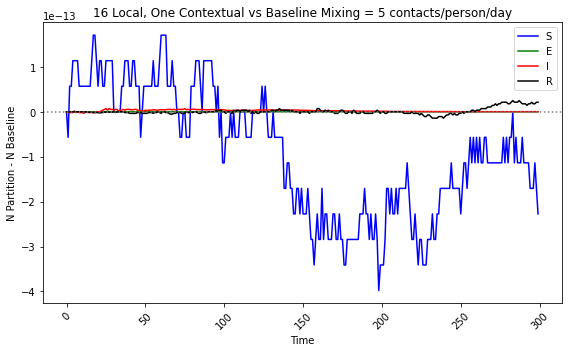

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

s16_diff_max.plot(ax=ax, color='b')
e16_diff_max.plot(ax=ax, color='g')
i16_diff_max.plot(ax=ax, color='r')
r16_diff_max.plot(ax=ax, color='k')

plt.legend(("S", "E", "I", "R"), loc=0)
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.title("16 Local, One Contextual vs Baseline Mixing = 5 contacts/person/day")
plt.tight_layout()
plt.ylabel("N Partition - N Baseline")
plt.axhline(y=0, c='gray', ls='dotted')
#ax.set_ylim(-2, 3)

plt.show()